In [1]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

sys.path.append(os.path.dirname(os.path.abspath(os.getcwd())) + "/..")
if os.getcwd().endswith("Topic2"):
    os.chdir("..")
    print(f"Changed to {os.getcwd()}")

from codebase import(
    transport_modes_dict, 
    trip_motives, 
    transport_mode_col, 
    IGNORE_RULES, 
    apply_ignore_rules,
    id_col,
    get_feature_importances,
    save_features_per_num, 
    load_features_per_num,
    run_transferable_classification
    )

from codebase.data_loading.load_odin import load_odin
run_ML = False
%load_ext autoreload
%autoreload 2

Changed to c:\Users\toell\Documents\GitHub\Design-of-AI-driven-business-operation


In [2]:
odin_df = load_odin()

[INFO] Loading ODiN data for years: [2019, 2020, 2021, 2022, 2023]
[INFO] Reading file: data\OdiN 2019-2023\OdiN 2019\ODiN2019_Databestand_v2.0.csv
Loaded file from CSV
[INFO] Loaded 179,091 rows for 2019
[INFO] Reading file: data\OdiN 2019-2023\OdiN 2020\ODiN2020_Databestand_v2.0.csv
Loaded file from CSV
[INFO] Loaded 176,729 rows for 2020
[INFO] Reading file: data\OdiN 2019-2023\OdiN 2021\ODiN2021_Databestand.csv
Loaded file from CSV
[INFO] Loaded 196,768 rows for 2021
[INFO] Reading file: data\OdiN 2019-2023\OdiN 2022\ODiN2022_Databestand.csv
Loaded file from CSV
[INFO] Loaded 200,054 rows for 2022
[INFO] Reading file: data\OdiN 2019-2023\OdiN 2023\ODiN2023_Databestand.csv
Loaded file from CSV
[INFO] Loaded 211,991 rows for 2023
[INFO] Total rows after concatenation: 964,633
[FILTER] Only-one-mode trips: 820,488 rows (filtered 144,145)
[FILTER] After ignore rules: 820,488 rows (filtered 0)
[DONE] Final dataset shape: (820488, 251)


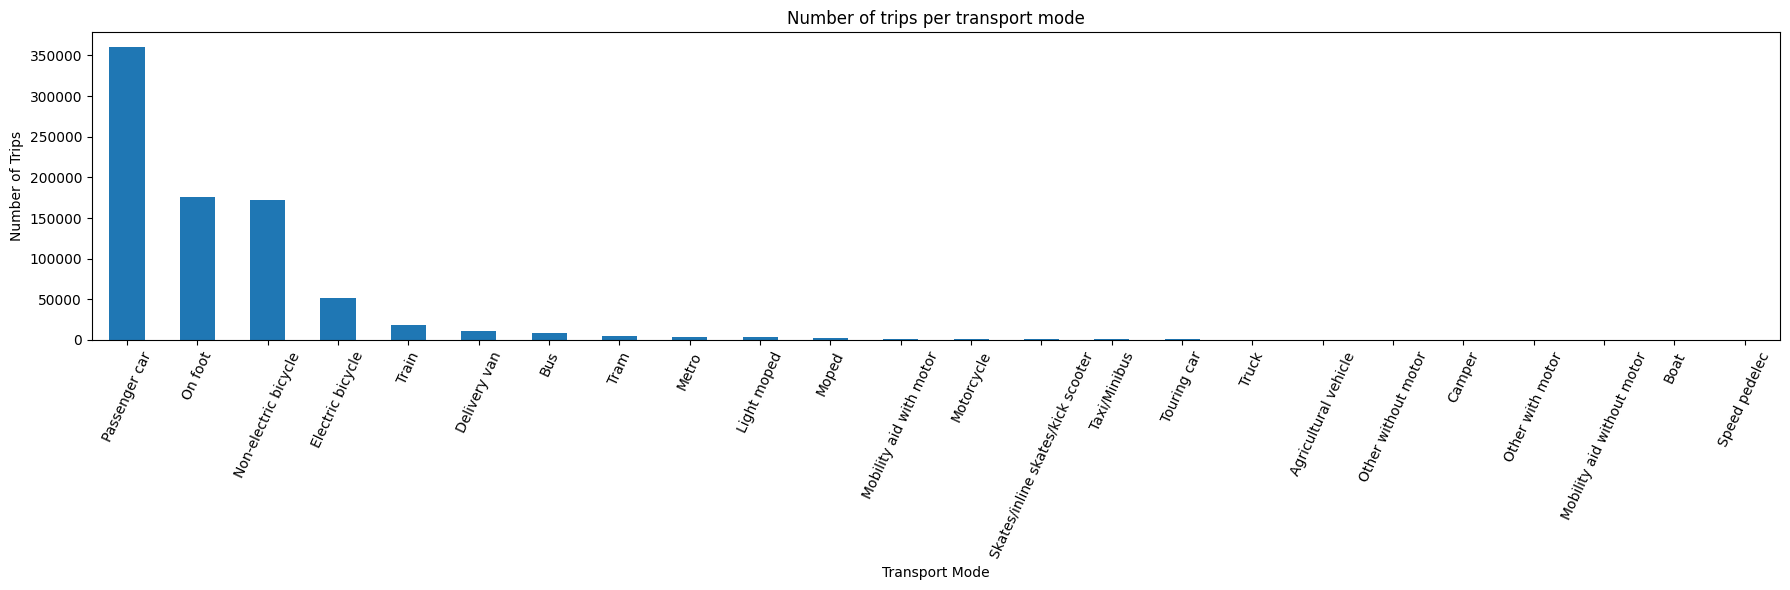

In [3]:
# Create a histogram for the number of trips for each transport mode and translate to 
ax = odin_df[transport_mode_col].value_counts().plot(kind="bar", title="Number of trips per transport mode", figsize=(18, 6))

ax.set_xticklabels([transport_modes_dict.get(int(float(label.get_text())), label.get_text()) for label in ax.get_xticklabels()], rotation=65)

plt.xlabel("Transport Mode")
plt.ylabel("Number of Trips")
plt.tight_layout()
plt.savefig("graphics/transport_modes_histogram.png", dpi=300)
plt.show()

Now a classifier that classifies what mode of transport was used

Common labels: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   10.8s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 100 out of 100 | elapsed:    0.5s finished


                                   precision    recall  f1-score   support

                    Passenger car       0.87      0.22      0.35     72639
                            Train       0.53      0.88      0.66      3556
                              Bus       0.29      0.56      0.38      1754
                             Tram       0.17      0.73      0.28       876
                            Metro       0.22      0.36      0.27       771
                    Speed pedelec       0.00      0.00      0.00        11
                 Electric bicycle       0.36      0.79      0.49     10265
             Non-electric bicycle       0.55      0.44      0.49     33908
                          On foot       0.80      0.46      0.58     35229
                      Touring car       0.03      0.18      0.05       137
                     Delivery van       0.13      0.34      0.19      2229
                            Truck       0.01      0.36      0.01        84
                        

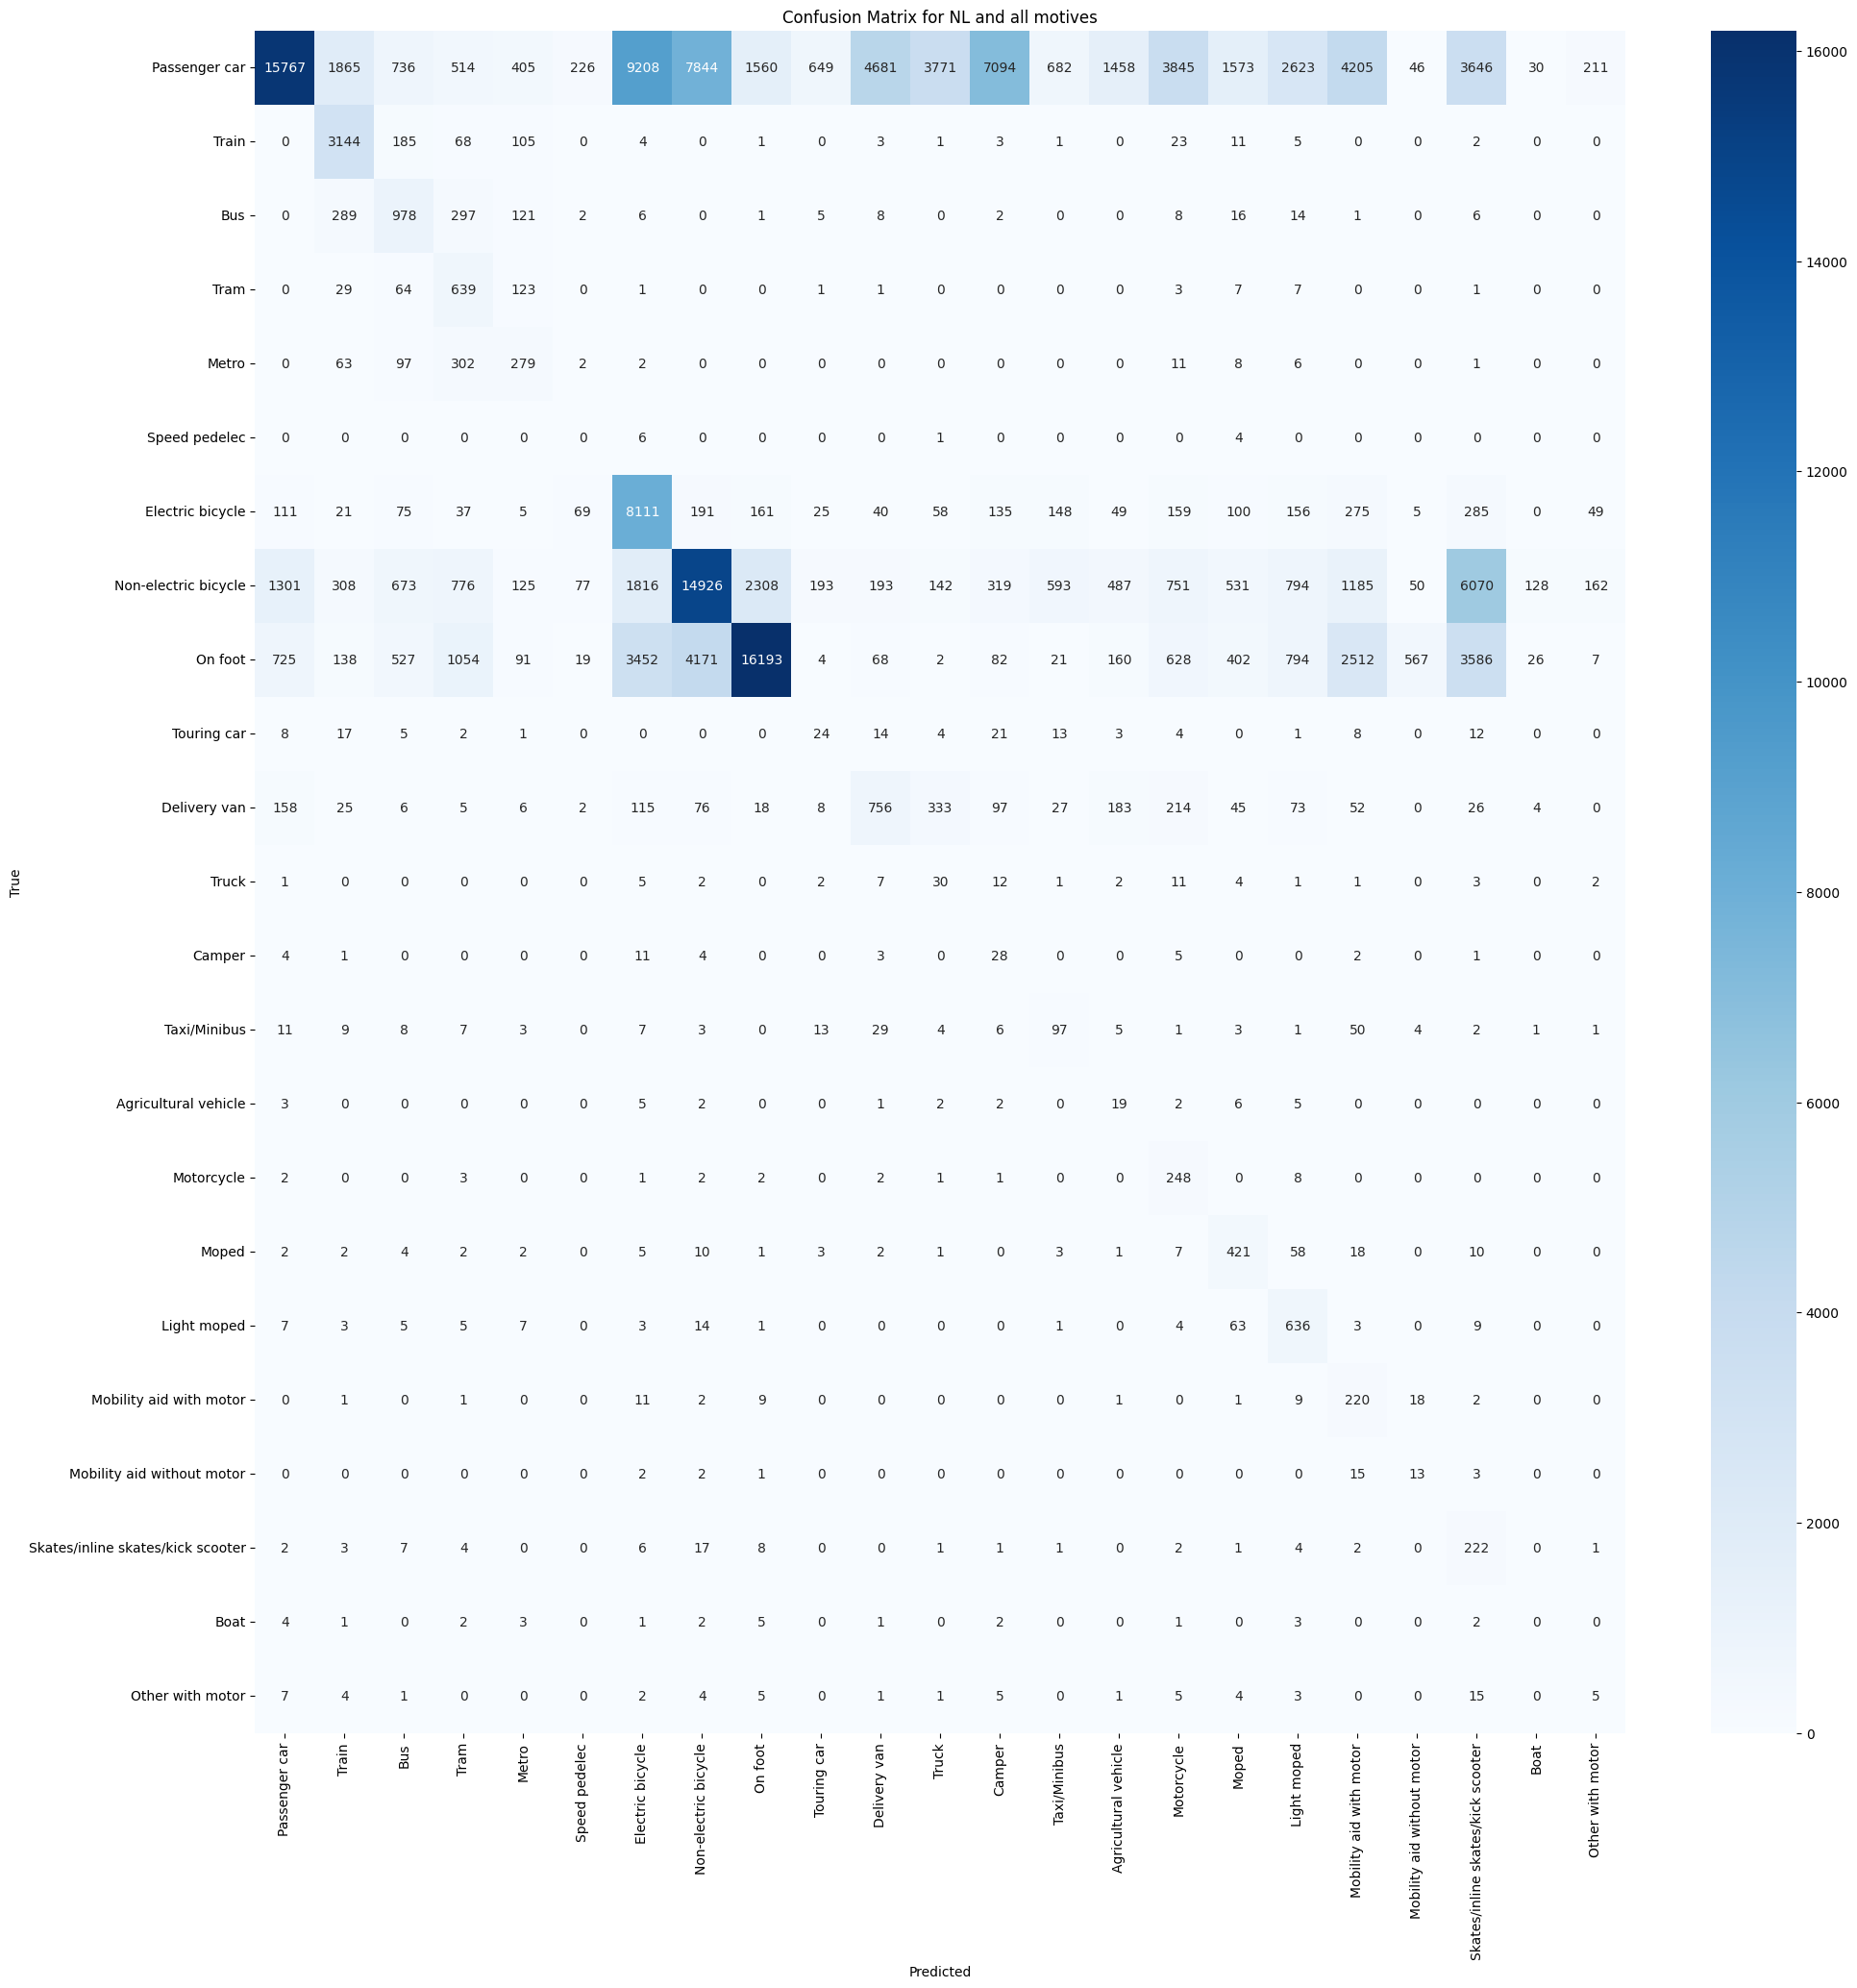

In [4]:
from codebase import (run_multiclass_classification,
                      distance_col, 
                      origin_col, 
                      province_codes, 
                      level_mapping_suffix, 
                      age_col, 
                      transport_mode_col, 
                      motive_col, 
                      urbanness_col,
                      categorical_cols)


df_multiclass = odin_df[odin_df[transport_mode_col] != odin_df[transport_mode_col].max()]
motives=None
origins=None#[7, 8, ]
location_level=2
origin_str = ', '.join(province_codes[code] for code in origins) if origins is not None else "NL"
motive_str = ', '.join(trip_motives[motive] for motive in motives) if motives is not None else "all motives"

pipeline_all, (X_train_all, _, _, _), accuracy = run_multiclass_classification(
    df_multiclass,
    test_size=0.2,
    destinations=None,
    origins=origins,
    location_level=location_level,
    categorical_features=categorical_cols,
    motives=motives,
    plot=True,
    savename=f"graphics/classification_results/multiclass/{level_mapping_suffix[location_level]}/full",
    plot_title=f"Confusion Matrix for {origin_str} and {motive_str}",
    verbose=True,
)

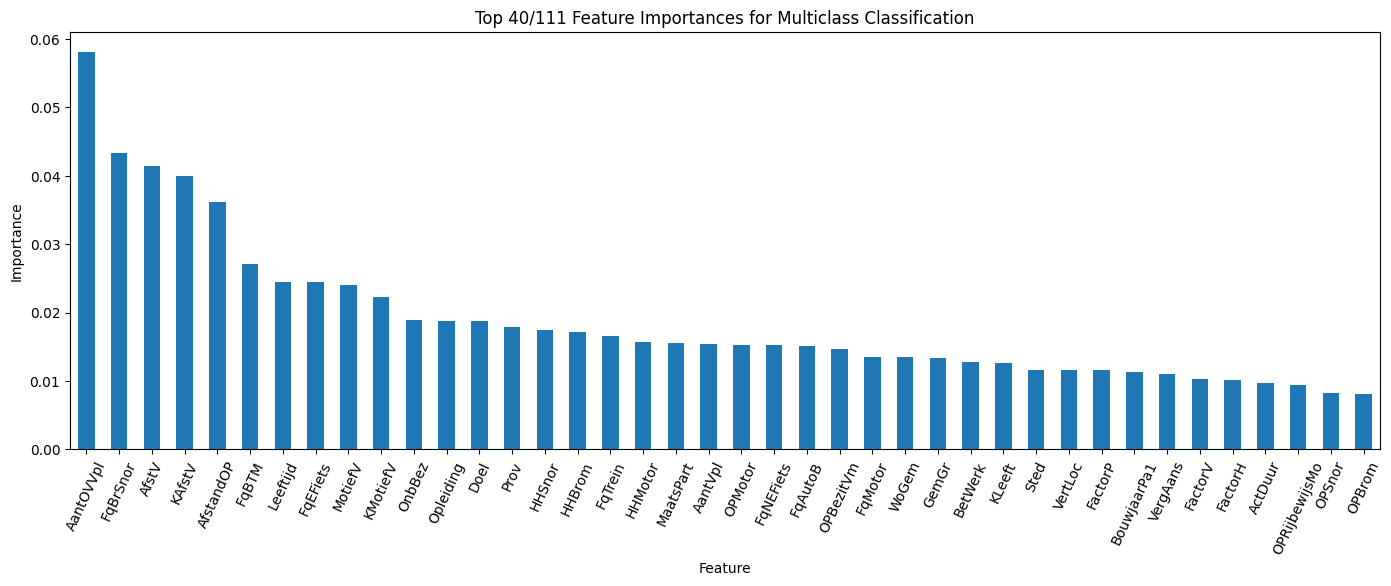

AankSPL      0.000856
AantOVVpl    0.058146
AantSVpl     0.001432
AantVpl      0.015446
AardWerk     0.006194
               ...   
VertLoc      0.011608
VertSPL      0.001257
VolgWerk     0.004767
WoGem        0.013478
WrkVerg      0.002579
Length: 111, dtype: float64

In [5]:
get_feature_importances(pipeline_all["model"].feature_importances_, top_n_for_plot=40, column_names=X_train_all.columns, savename=f"graphics/classification_results/multiclass/feature_importances_all.png")

In [6]:
from codebase import urbanness_col, motive_col

age_range = (0, np.inf)
vehicles_to_include = [1, 7, 8, 9, ]

df_less_vehicles = df_multiclass[df_multiclass[transport_mode_col].isin(vehicles_to_include)]
df_less_vehicles: pd.DataFrame = df_less_vehicles[(df_less_vehicles[age_col] < age_range[1]) & (df_less_vehicles[age_col] > age_range[0])]

Common labels: [1 7 8 9]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    8.8s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 100 out of 100 | elapsed:    0.1s finished


                      precision    recall  f1-score   support

       Passenger car       0.90      0.72      0.80     72043
    Electric bicycle       0.39      0.89      0.54     10436
Non-electric bicycle       0.63      0.77      0.70     34755
             On foot       0.83      0.68      0.75     35423

            accuracy                           0.73    152657
           macro avg       0.69      0.76      0.70    152657
        weighted avg       0.79      0.73      0.74    152657



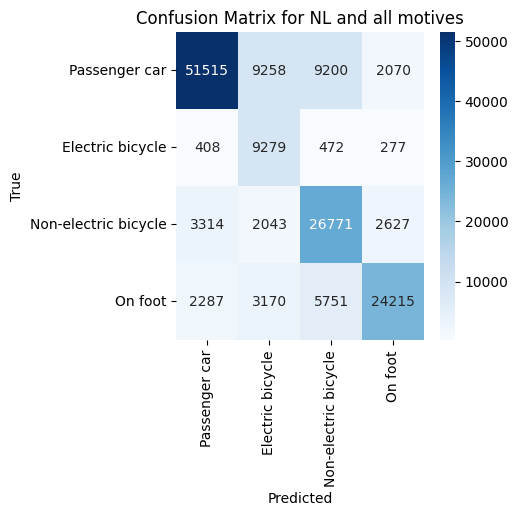

In [7]:
location_level=2
origin_str = ', '.join(province_codes[code] for code in origins) if origins is not None else "NL"
motive_str = ', '.join(trip_motives[motive] for motive in motives) if motives is not None else "all motives"

pipeline_less, (X_train_less, _, _, _), accuracy = run_multiclass_classification(
    df_less_vehicles,
    test_size=0.2,
    destinations=None,
    origins=origins,
    location_level=location_level,
    categorical_features=categorical_cols,
    motives=motives,
    plot=True,
    savename=f"graphics/classification_results/multiclass/{level_mapping_suffix[location_level]}/less_vehicles",
    plot_title=f"Confusion Matrix for {origin_str} and {motive_str}",
)

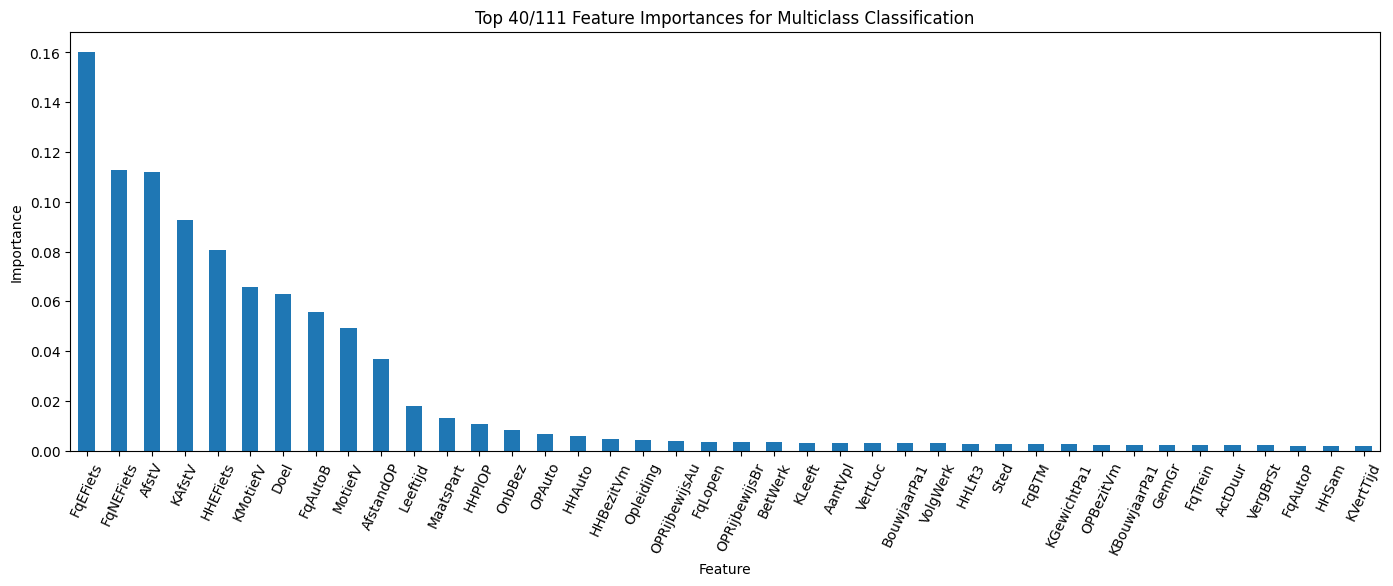

In [8]:
grouped_importances_less = get_feature_importances(pipeline_less["model"].feature_importances_, column_names=X_train_less.columns, top_n_for_plot=40, savename=f"graphics/classification_results/multiclass/feature_importances_less_vehicles.png")

Now keep the top N

In [9]:
"Hvm" in df_less_vehicles.columns

True

Decide whether or not to run the random forest loop with decreasing number of features present

In [10]:
overwrite = False

feature_savename = "data/features_per_num.pkl"
accs_savename = "data/accuracies_per_num.pkl"

In [11]:
if os.path.exists(feature_savename) and not overwrite:
    features_per_num, accs = load_features_per_num(feature_savename, accs_savename)
    nums = list(features_per_num.keys())
else:
    prev_grouped_importances = grouped_importances_less

    nums = [200, 100, 50, 25, 15, 10, 8, 5, 4, 3, 2, 1]
    accs = []
    features_per_num = dict()

    for num_keep in nums:
        prev_grouped_importances = prev_grouped_importances.sort_values(ascending=False)[:num_keep]

        cols_to_drop = [col for col in df_less_vehicles.columns if col not in list(prev_grouped_importances.index) + [transport_mode_col, id_col]]
        df_keep_loop = df_less_vehicles.drop(columns=cols_to_drop)
        print(f"Keeping {len(df_keep_loop.columns)} columns after dropping {len(cols_to_drop)} columns.")

        pipeline_keep_loop, (X_train, _, _, _), accuracy = run_multiclass_classification(
            df_keep_loop,
            test_size=0.2,
            destinations=None,
            origins=origins,
            location_level=location_level,
            categorical_features=categorical_cols,
            motives=motives,
            plot=True,
            savename=f"graphics/classification_results/multiclass/{level_mapping_suffix[location_level]}/less_vehicles_{num_keep}",
            plot_title=f"Confusion Matrix for {origin_str} and {motive_str} using {num_keep} features",
            verbose=True,
        )


        prev_grouped_importances = get_feature_importances(
            pipeline_keep_loop["model"].feature_importances_, 
            column_names=X_train.columns, 
            top_n_for_plot=40, 
            savename=f"graphics/classification_results/multiclass/feature_importances_less_vehicles_{num_keep}.png"
        )
        accs.append(accuracy)

        features_per_num[num_keep] = prev_grouped_importances
    save_features_per_num(features_per_num, accs, feature_savename, accs_savename)

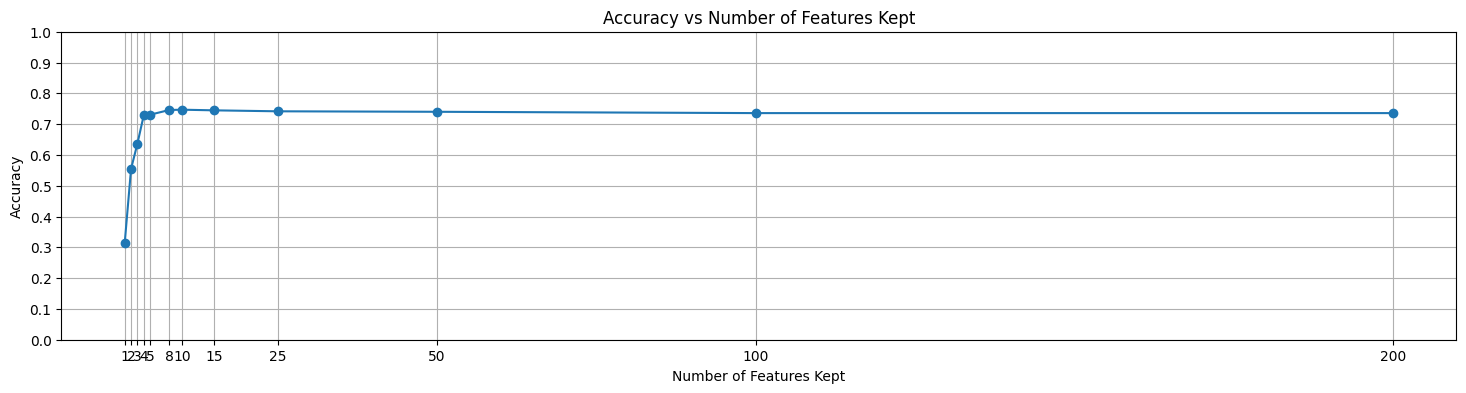

In [12]:
plt.figure(figsize=(18, 4))
plt.plot(nums, accs, marker='o')
plt.title("Accuracy vs Number of Features Kept")
plt.xlabel("Number of Features Kept")
plt.ylabel("Accuracy")
# plt.xscale('log')
plt.xticks(nums)
plt.yticks(np.arange(0, 1.1, 0.1))
plt.grid(True)
plt.savefig("graphics/classification_results/multiclass/accuracy_vs_num_features.png", dpi=300)
plt.show()

Common labels: [1 7 8 9]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    4.0s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 100 out of 100 | elapsed:    0.1s finished


                      precision    recall  f1-score   support

       Passenger car       0.91      0.72      0.80     72043
    Electric bicycle       0.42      0.88      0.57     10436
Non-electric bicycle       0.65      0.78      0.71     34755
             On foot       0.81      0.72      0.77     35423

            accuracy                           0.75    152657
           macro avg       0.70      0.78      0.71    152657
        weighted avg       0.79      0.75      0.76    152657



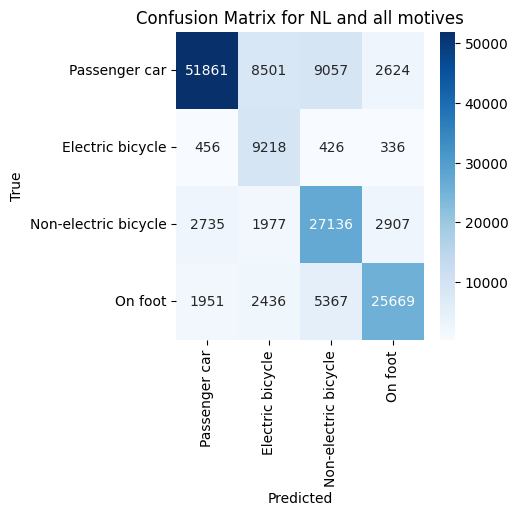

In [13]:
num_to_replicate = 10

# categorical_cols_for_small = [
#     urbanness_col, 
#     age_col,
#     distance_col,
#     motive_col,
#     "KAfstV",
#     "Doel"
# ] 

cols_to_keep = features_per_num[num_to_replicate].index.to_list() + [id_col]
cols_to_drop = [col for col in df_less_vehicles.columns if col not in cols_to_keep + [transport_mode_col]]

pipeline_transferable, (X_train, _, _, _), accuracy = run_multiclass_classification(
    df_less_vehicles,
    test_size=0.2,
    destinations=None,
    origins=origins,
    location_level=location_level,
    categorical_features=categorical_cols,
    drop_cols=cols_to_drop,
    motives=motives,
    plot=True,
    savename=f"graphics/classification_results/multiclass/transferable_forest_{num_to_replicate}",
    plot_title=f"Confusion Matrix for {origin_str} and {motive_str}",
)

File data/classification_results/multiclass/transferable_classification_results_7_6_50.csv already exists. Loading existing results.


c:\Users\toell\Documents\GitHub\Design-of-AI-driven-business-operation\codebase\plotting\plots.py:102: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend(loc='upper right', fontsize='small')
c:\Users\toell\Documents\GitHub\Design-of-AI-driven-business-operation\codebase\plotting\plots.py:102: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='upper right', fontsize='small')


<Figure size 1000x1000 with 0 Axes>

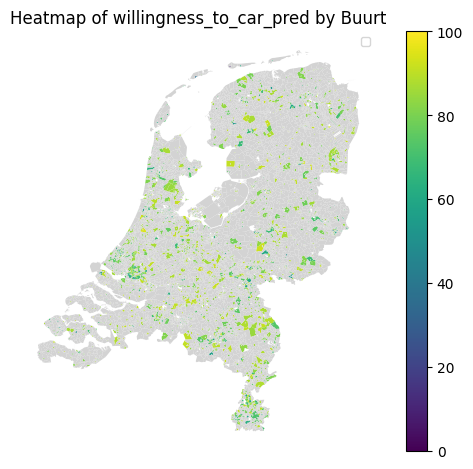

c:\Users\toell\Documents\GitHub\Design-of-AI-driven-business-operation\codebase\plotting\plots.py:102: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend(loc='upper right', fontsize='small')
c:\Users\toell\Documents\GitHub\Design-of-AI-driven-business-operation\codebase\plotting\plots.py:102: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='upper right', fontsize='small')


<Figure size 1000x1000 with 0 Axes>

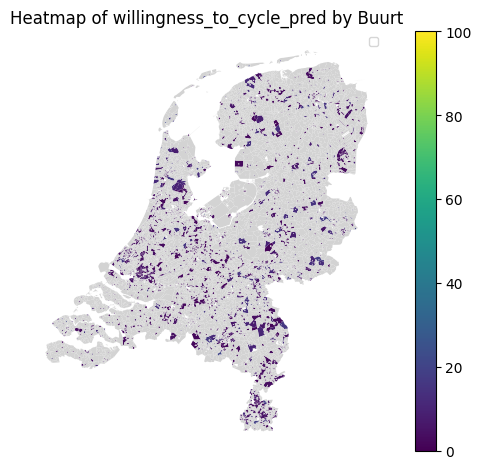

c:\Users\toell\Documents\GitHub\Design-of-AI-driven-business-operation\codebase\plotting\plots.py:102: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend(loc='upper right', fontsize='small')
c:\Users\toell\Documents\GitHub\Design-of-AI-driven-business-operation\codebase\plotting\plots.py:102: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='upper right', fontsize='small')


<Figure size 1000x1000 with 0 Axes>

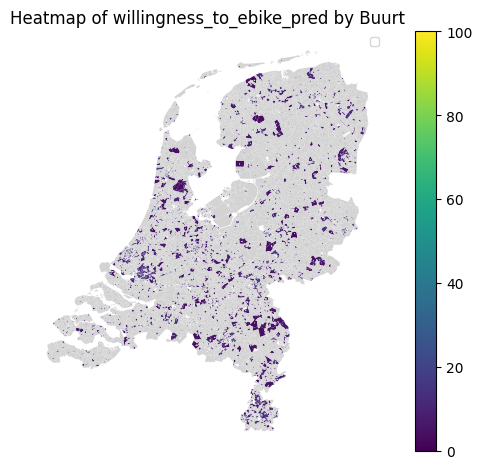

c:\Users\toell\Documents\GitHub\Design-of-AI-driven-business-operation\codebase\plotting\plots.py:102: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend(loc='upper right', fontsize='small')
c:\Users\toell\Documents\GitHub\Design-of-AI-driven-business-operation\codebase\plotting\plots.py:102: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='upper right', fontsize='small')


<Figure size 1000x1000 with 0 Axes>

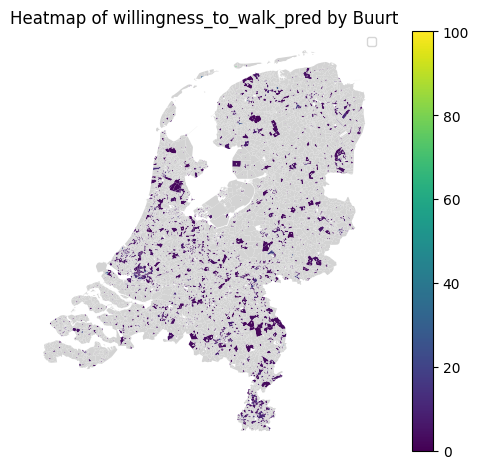

In [14]:
from codebase import run_transferable_classification
cols_for_transferable = features_per_num[num_to_replicate].index.to_list()

df_with_probs = run_transferable_classification(
    odin_df=odin_df,
    pipeline_transferable=pipeline_transferable,
    cols_for_transferable=cols_for_transferable,
    necessary_columns=X_train.columns,
    col_car_pred = "willingness_to_car_pred",
    col_cycle_pred = "willingness_to_cycle_pred",
    col_ebike_pred = "willingness_to_ebike_pred",
    col_walk_pred = "willingness_to_walk_pred",
    threshold_datapoints=50,
    overwrite_existing=False
)

In [15]:
X_train[X_train.isna()]

,HHEFiets,FqNEFiets,FqEFiets,FqAutoB,AfstandOP,AfstV,KAfstV,Doel_2.0,Doel_3.0,Doel_4.0,...,MotiefV_12.0,MotiefV_13.0,KMotiefV_2.0,KMotiefV_3.0,KMotiefV_4.0,KMotiefV_5.0,KMotiefV_6.0,KMotiefV_7.0,KMotiefV_8.0,KMotiefV_9.0
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
964621,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
964622,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
964623,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
964625,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
odin_df[odin_df.notna()]

,OP,OPID,Steekproef,Mode,HHPers,HHSam,HHPlOP,HHLft1,HHLft2,HHLft3,...,BerHalte,RdHalteA,RdHalteB,BerFam,RdFamA,RdFamB,BerSport,RdSportA,RdSportB,HerkLand
0,1,56144136518,1,1,4.0,3,3,1.0,1.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,56144136518,1,1,4.0,3,3,1.0,1.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,56144148453,1,1,4.0,3,4,0.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,56144148453,1,1,4.0,3,4,0.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,56144148453,1,1,4.0,3,4,0.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
964628,0,279999888969,1,1,4.0,3,3,0.0,2.0,0.0,...,1.0,13.0,13.0,1.0,13.0,13.0,1.0,13.0,13.0,1.0
964629,0,279999888969,1,1,4.0,3,3,0.0,2.0,0.0,...,1.0,13.0,13.0,1.0,13.0,13.0,1.0,13.0,13.0,1.0
964630,0,279999888969,1,1,4.0,3,3,0.0,2.0,0.0,...,1.0,13.0,13.0,1.0,13.0,13.0,1.0,13.0,13.0,1.0
964631,0,279999888969,1,1,4.0,3,3,0.0,2.0,0.0,...,1.0,13.0,13.0,1.0,13.0,13.0,1.0,13.0,13.0,1.0


In [17]:
no_na_cols = odin_df.dropna(axis=1).columns.to_list()
print([col for col in cols_for_transferable if col in no_na_cols])

['AfstV', 'AfstandOP', 'Doel', 'FqAutoB', 'FqEFiets', 'FqNEFiets', 'HHEFiets', 'KAfstV', 'KMotiefV', 'MotiefV']
